In [52]:
# get the relevant dependencies 
import json
import os
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from event_model import event_model as em

In [53]:
# read in the events -> from the folder choosen 
all_considered_events = []

# here we could plug in the events from cern that we got send i would actually like to do that
# for (dirpath, dirnames, filenames) in os.walk(os.path.abspath(os.path.join('..', 'events'))):
for (dirpath, dirnames, filenames) in os.walk(os.path.abspath(os.path.join('..','..', 'events_minbias_mag_down_run3'))):
    for i, filename in enumerate(filenames):
        # Get an event
        f = open(os.path.realpath(os.path.join(dirpath, filename)))
        json_data = json.loads(f.read())
        all_considered_events = all_considered_events + [em.event(json_data)]
        f.close()
        
        # lets take the first 50 event fromt he new dataset
        if i == 50:
            break


In [54]:
#os.path.abspath(os.path.join('..','..', 'events_minbias_mag_down_run3'))
print(all_considered_events)

[<event_model.event_model.event object at 0x7fb65f4f46a0>, <event_model.event_model.event object at 0x7fb65f4f4400>, <event_model.event_model.event object at 0x7fb65a2121f0>, <event_model.event_model.event object at 0x7fb65a989580>, <event_model.event_model.event object at 0x7fb65afa9160>, <event_model.event_model.event object at 0x7fb65b5de4f0>, <event_model.event_model.event object at 0x7fb65c08a8b0>, <event_model.event_model.event object at 0x7fb65c498550>, <event_model.event_model.event object at 0x7fb65c2a13d0>, <event_model.event_model.event object at 0x7fb65caf2a30>, <event_model.event_model.event object at 0x7fb660eaf280>, <event_model.event_model.event object at 0x7fb660f3f1c0>, <event_model.event_model.event object at 0x7fb66107d460>, <event_model.event_model.event object at 0x7fb6610ffeb0>, <event_model.event_model.event object at 0x7fb6611a50d0>, <event_model.event_model.event object at 0x7fb661201520>, <event_model.event_model.event object at 0x7fb6612da400>, <event_model.

In [57]:
# is the distance beween the parts of one module always the same?
event = all_considered_events[0] # take the first of the elements for this check

event.module_zs
for module in event.module_zs:
    print(module)
    print(list(module)[0]-list(module)[1])
    # pretty damn the same
    break
print(len(event.module_zs)) # -> 52 modules with two parts always
    

{-288.08, -286.918}
-1.1619999999999777
52


In [69]:
event.modules

[module 0:
  At z: {-288.08, -286.918}
  Number of hits: 35
  Hits (#id {x, y, z}): [#0 module 0 {13.905, -27.145, -288.08}, #1 module 0 {-8.087, -15.847, -288.08}, #2 module 0 {-0.6, -8.438, -288.08}, #3 module 0 {-0.483, -7.855, -288.08}, #4 module 0 {-1.728, -7.777, -288.08}, #5 module 0 {-0.989, -6.572, -288.08}, #6 module 0 {-2.661, -7.933, -288.08}, #7 module 0 {-1.339, -6.61, -288.08}, #8 module 0 {-6.434, -9.138, -288.08}, #9 module 0 {-5.889, -2.812, -288.08}, #10 module 0 {-8.475, -9.508, -288.08}, #11 module 0 {-11.182, -5.154, -288.08}, #12 module 0 {-20.7, -15.64, -286.918}, #13 module 0 {-13.194, -25.091, -286.918}, #14 module 0 {-8.527, -23.613, -286.918}, #15 module 0 {-2.654, -25.907, -286.918}, #16 module 0 {-2.071, -34.58, -286.918}, #17 module 0 {-8.127, 11.724, -286.918}, #18 module 0 {-5.016, 6.279, -286.918}, #19 module 0 {-11.88, 12.366, -286.918}, #20 module 0 {-6.805, 4.101, -286.918}, #21 module 0 {-11.802, 8.399, -286.918}, #22 module 0 {-7.077, 1.962, -286.

In [5]:
# particle class to properly handle the real tracks -> might want to plot angles where we see the highest density
class particle(object):
    def __init__(self, particle, event):
        self.key = particle[0]
        self.pid = particle[1]
        self.p = particle[2]
        self.pt = particle[3]
        self.eta = particle[4]
        self.phi = particle[5]
        self.isLong = particle[6]
        self.isDown = particle[7]
        self.hasVelo = particle[8]
        self.hasUT = particle[9]
        self.hasScifi = particle[10]
        #self.fromBeautyDecay = particle[11]
        #self.fromCharmDecay = particle[12]
        #self.fromStrangeDecay = particle[13]
        self.charge = particle[14]
        self.hits = particle[15]
        self.track = [hit for hit in event.hits if hit.id in self.hits]
        self.is_decay = particle[11] or particle[12] or particle[13]

In [6]:
#print(event.hits[6].id) 
# nice! id matches position in hitlist
num_events = len(all_considered_events)
print(f'we look at {num_events} events \n')

all_particles = []
for idx, event in enumerate(all_considered_events): 
    #noise_hits = event.hits.copy()
    print(f'{idx/(num_events-1)}% done')
    
    for part in event.montecarlo.get('particles'):
        temp_particle = particle(part, event)
        all_particles = all_particles + [temp_particle]
        #for hit in temp_particle.track:
            #if noise_hits:
                # implicitl asserting a hit only apears on one track
                #noise_hits = noise_hits.remove(hit)

    # no noise in here!
    # print(noise_hits)


we look at 51 events 

0.0% done
0.02% done
0.04% done
0.06% done
0.08% done
0.1% done
0.12% done
0.14% done
0.16% done
0.18% done
0.2% done
0.22% done
0.24% done
0.26% done
0.28% done
0.3% done
0.32% done
0.34% done
0.36% done
0.38% done
0.4% done
0.42% done
0.44% done
0.46% done
0.48% done
0.5% done
0.52% done
0.54% done
0.56% done
0.58% done
0.6% done
0.62% done
0.64% done
0.66% done
0.68% done
0.7% done
0.72% done
0.74% done
0.76% done
0.78% done
0.8% done
0.82% done
0.84% done
0.86% done
0.88% done
0.9% done
0.92% done
0.94% done
0.96% done
0.98% done
1.0% done


In [7]:
# Lets analyse angles of the particles (distribution of this)
all_angles = []
num_hits = []
print(f'number of particles were looking at {len(all_particles)}')

for particle in all_particles:
    all_angles = all_angles + [particle.phi]
    num_hits = num_hits + [len(particle.track)]

number of particles were looking at 16293


In [8]:
import math

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))


In [9]:
## need to check how phi is calculated
 
# i think its the angle between two vectors, one is the beam line (0,0,1) vector and the second can be constructed
# with 2 hits

# can not solve the angle problem at the moment because we can not calc 360° angles in 3d space. dont know what the phi is

# choose here any number to look at a particle
temp_track = all_particles[2100]
print(temp_track.track)
#print(temp_track.fromBeautyDecay)
#print(temp_track.fromCharmDecay)
#print(temp_track.fromStrangeDecay)
#print(temp_track.hasUT) #?
#print(temp_track.hasScifi) #?

# remarkable -> no decay and starts in module 45

for i in range(len(temp_track.track)-2):
    hit_1 = temp_track.track[i]
    hit_2 = temp_track.track[i+1]
    # assuming the track goes in direction of the z 
    v_beam = (0,0,1)
    v_hits = (hit_2.x - hit_1.x,hit_2.y - hit_1.y,hit_2.z - hit_1.z )
    print(temp_track.phi)
    print(angle2(v_beam,v_hits))

[#21 module 1 {0.613, 32.812, -274.418}, #49 module 3 {0.594, 30.07, -249.418}, #76 module 5 {0.516, 27.347, -224.418}, #96 module 7 {0.484, 24.735, -200.58}, #117 module 9 {0.348, 16.587, -125.58}, #136 module 11 {0.186, 8.439, -50.58}]
1.545


NameError: name 'angle2' is not defined

0.3796108758362487


(array([ 20.,  13.,   8.,  12., 190., 178., 673., 670., 895., 825., 380.,
        453., 479., 427., 525., 533., 545., 617., 634., 580., 510., 466.,
        397., 395., 391., 390., 362., 333., 270., 279., 248., 256., 223.,
        177., 193., 148., 181., 148., 244., 215., 297., 223., 287., 253.,
        234., 228., 135., 107.,   8.,   5.,  13.,  20.]),
 array([ 0.        ,  0.98076923,  1.96153846,  2.94230769,  3.92307692,
         4.90384615,  5.88461538,  6.86538462,  7.84615385,  8.82692308,
         9.80769231, 10.78846154, 11.76923077, 12.75      , 13.73076923,
        14.71153846, 15.69230769, 16.67307692, 17.65384615, 18.63461538,
        19.61538462, 20.59615385, 21.57692308, 22.55769231, 23.53846154,
        24.51923077, 25.5       , 26.48076923, 27.46153846, 28.44230769,
        29.42307692, 30.40384615, 31.38461538, 32.36538462, 33.34615385,
        34.32692308, 35.30769231, 36.28846154, 37.26923077, 38.25      ,
        39.23076923, 40.21153846, 41.19230769, 42.17307692, 43

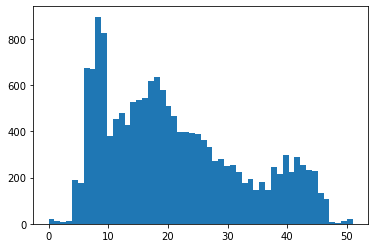

In [20]:
################ getting the first and last hit of all the ###################
# i define origin hit as the one with closest distance to z axis
# i define the last hit as the one with furtherst distance from the z axis
# i guess i only need to look at the first and last hit of one particle -> have not seen smth else
min_hits = []
max_hits = []
count_reverse = 0
for particle in all_particles:
    hit1 = particle.track[0]    
    hit2 = particle.track[-1]
    
    if math.sqrt(hit1.x**2 + hit1.y**2) < math.sqrt(hit2.x**2 + hit2.y**2):
        min_hits = min_hits + [hit1]
        max_hits = max_hits + [hit2]
    else:
        # this happens
        min_hits = min_hits + [hit2]
        max_hits = max_hits + [hit1]
        count_reverse += 1
    
print(count_reverse/len(min_hits))
############## hist the distr of closest and furthest hits #############

plt.hist([hit.module_number for hit in min_hits], bins = 52)


(array([1996., 1853.,  162.,  173.,  156.,  165.,   86.,  107.,  259.,
         203.,  287.,  230.,   96.,   96.,  104.,  119.,  116.,  117.,
         126.,  132.,  143.,  173.,  167.,  172.,  184.,  193.,  184.,
         163.,  167.,  173.,  187.,  178.,  207.,  161.,  167.,  144.,
         282.,  263.,  350.,  355.,  348.,  349.,  277.,  249.,  134.,
         133.,  118.,  123.,  122.,  126., 1919., 1799.]),
 array([ 0.        ,  0.98076923,  1.96153846,  2.94230769,  3.92307692,
         4.90384615,  5.88461538,  6.86538462,  7.84615385,  8.82692308,
         9.80769231, 10.78846154, 11.76923077, 12.75      , 13.73076923,
        14.71153846, 15.69230769, 16.67307692, 17.65384615, 18.63461538,
        19.61538462, 20.59615385, 21.57692308, 22.55769231, 23.53846154,
        24.51923077, 25.5       , 26.48076923, 27.46153846, 28.44230769,
        29.42307692, 30.40384615, 31.38461538, 32.36538462, 33.34615385,
        34.32692308, 35.30769231, 36.28846154, 37.26923077, 38.25      ,
  

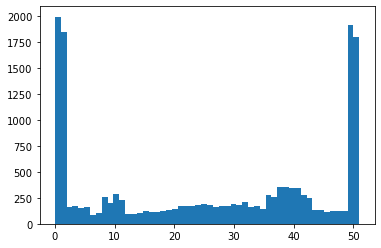

In [21]:
plt.hist([hit.module_number for hit in max_hits], bins = 52)

In [70]:
################ checking how many tracks cross the beam line ##################
################ also checking how many tracks dont have consecutive triplets ##########
# the consecutive thing is really not nice
beam_crossing_particles = []
no_cosecutive_triplet = []

# id say we have a beam cross if either x or y change sign among hits
for particle in all_particles:
    x_p, x_n, y_p, y_n, = False, False, False, False
    triplet = 0
    last_module = -2
    for hit in particle.track:
        x_p = hit.x >0 or x_p
        x_n = hit.x <0 or x_n
        y_p = hit.y >0 or y_p
        y_n = hit.y <0 or y_n
        
        if triplet < 3:
            if hit.module_number in (last_module + 1,last_module + 2):
                triplet += 1
                last_module = hit.module_number
            else:
                triplet = 1
                last_module = hit.module_number
                
    if x_p + x_n + y_p + y_n > 2:
        beam_crossing_particles = beam_crossing_particles + [particle]
    if triplet < 3:
        no_cosecutive_triplet = no_cosecutive_triplet + [particle]
print(len(all_particles))
print('beam_crossing')
print(len(beam_crossing_particles))
print(len(beam_crossing_particles)/len(all_particles))
print('no_co')
print(len(no_cosecutive_triplet))
print(len(no_cosecutive_triplet)/len(all_particles))


# 5% of the tracks seem to cross the line

16293
beam_crossing
775
0.04756643957527772
no_co
426
0.02614619775363653


In [71]:
0.99**3

0.970299

In [67]:
no_cosecutive_triplet[10000].track

[#1377 module 13 {3.15, -4.567, -24.418},
 #1557 module 15 {5.347, -7.464, 0.581},
 #1715 module 17 {7.72, -10.537, 25.581},
 #1894 module 19 {10.014, -13.609, 50.581},
 #2136 module 21 {12.153, -16.604, 74.419},
 #2341 module 23 {14.642, -19.715, 99.419},
 #2761 module 27 {19.562, -25.801, 149.419}]

In [60]:
decay = 0
for particle in all_particles:
    if particle.is_decay:
        decay +=1
print(decay)
# abput 5% of particles from decay

977


In [59]:
decay = 0
for particle in beam_crossing_particles:
    if particle.is_decay:
        decay +=1
print(decay)
# ~20%

132


In [87]:
beam_crossing_particles[20].track

[#1667 module 34 {-0.367, -13.98, 236.919},
 #1768 module 36 {0.268, -21.622, 261.919},
 #1915 module 38 {1.642, -36.972, 313.081}]

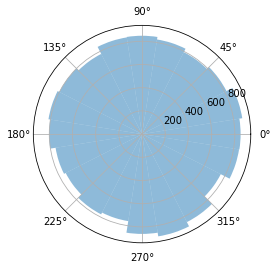

In [16]:
import numpy as np
import matplotlib.pyplot as plt

############### I cant tell if this plots the angles correctly #########
# I think its correct because we get such a nice distribution

bins_number = 20  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
angles = [(np.pi + angle) for angle in all_angles]
n, _, _ = plt.hist(angles, bins)

plt.clf()
width = 2 * np.pi / bins_number
ax = plt.subplot(1, 1, 1, projection='polar')
bars = ax.bar(bins[:bins_number], n, width=width, bottom=0.0)
for bar in bars:
    bar.set_alpha(0.5)
plt.show()

In [ ]:
################ here I want to check what is the max and expected deviation of points from the line ############
for particle in all_particles:
    particle.track

In [75]:
#from sklearn.linear_model import LinearRegression

def track_regression_analysis(particle):
    my_arr = np.zeros((len(particle.track),2))
    z = np.zeros((len(particle.track),1))
    for i, hit in enumerate(particle.track):
        my_arr[i,0] = hit.x        
        my_arr[i,1] = hit.y
        z[i] = hit.z
        
    x_reg = LinearRegression().fit(z,my_arr[:,0])
    y_reg = LinearRegression().fit(z,my_arr[:,1])
    
    # hit 0 
    hit0 = particle.track[0]
    x_pred = x_reg.predict(np.array([hit0.z]).reshape(-1, 1))
    y_pred = y_reg.predict(np.array([hit0.z]).reshape(-1, 1))
    pred = (x_pred,y_pred)
    
    max_dev_hit = math.sqrt((x_pred[0]-hit0.x)**2 + (y_pred[0]-hit0.y)**2)
    # got stuck here...
    for hit in particle.track[1:]:
        x_pred = x_reg.predict(np.array([hit.z]).reshape(-1, 1))
        y_pred = y_reg.predict(np.array([hit.z]).reshape(-1, 1))
        new_deviation = math.sqrt((x_pred[0]-hit.x)**2 + (y_pred[0]-hit.y)**2)
        if new_deviation >  max_dev_hit:
            max_dev_hit = new_deviation
            hit0 = hit
            should_be = ()
            pred = (x_pred,y_pred)
    return max_dev_hit, hit, pred
    

print(track_regression_analysis(all_particles[0]))
    

(0.5714418257391403, #1188 module 38 {-12.338, -31.702, 313.081}, (array([-10.54742857]), array([-27.80592857])))
